# Problem statement
- Creating custom Call Backs in Tensorflow with the given model...


### 1. Download the data from <a href='https://drive.google.com/file/d/15dCNcmKskcFVjs7R0ElQkR61Ex53uJpM/view?usp=sharing'>here</a>. we have to use data.csv file for this project
### 2. Code the model to classify data like below image. we can use any number of units in your Dense layers.

<img src='https://i.imgur.com/33ptOFy.png'>



In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Activation
from tensorflow.keras.models import Model
import random as rn
from tensorflow import keras
import datetime, os

from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score, f1_score

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving data.csv to data.csv


In [ ]:
import io
 
data = pd.read_csv(io.BytesIO(uploaded['data.csv']))
print(data)

             f1        f2  label
0      0.450564  1.074305    0.0
1      0.085632  0.967682    0.0
2      0.117326  0.971521    1.0
3      0.982179 -0.380408    0.0
4     -0.720352  0.955850    0.0
...         ...       ...    ...
19995 -0.491252 -0.561558    0.0
19996 -0.813124  0.049423    1.0
19997 -0.010594  0.138790    1.0
19998  0.671827  0.804306    0.0
19999 -0.854865 -0.588826    0.0

[20000 rows x 3 columns]


In [ ]:
y=data['label'].values
x=data[["f1","f2"]].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25,stratify=y)

# <font color='red'> <b>3. Writing Callbacks </b> </font>
## we are implementing the following callbacks
-  Write our own callback function, that has to print the micro F1 score and AUC score after each epoch.we can not use tf.keras.metrics for calculating AUC and F1 score.

- Save your model at every epoch if your validation accuracy is improved from previous epoch. 

- we have to decay learning based on below conditions 
        Cond1. If your validation accuracy at that epoch is less than previous epoch accuracy, we have to decrese the
               learning rate by 10%. 
        Cond2. For every 3rd epoch, decay our learning rate by 5%.
        
- If we are getting any NaN values(either weigths or loss) while training, we have to terminate your training. 

- we have to stop the training if our validation accuracy is not increased in last 2 epochs.

- Use tensorboard for every model and analyse our scalar plots and histograms.



In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
class custom_metrics(tf.keras.callbacks.Callback):
  def __init__(self,validation_data,patience=2):
    self.X_val, self.y_val = validation_data
    self.patience = patience
    self.best_val_acc = 0.0
    self.best_model_weights = None


  def on_train_begin(self, logs={}):
    self.learning_rate = self.model.optimizer.learning_rate

  def on_epoch_end(self, epoch, logs={}):
    # Calculate the micro F1 score and AUC score
    y_pred = (np.asarray(self.model.predict(self.X_val))).round()
    #y_pred = np.argmax(self.model.predict(self.X_val), axis=-1)
    f1 = f1_score(self.y_val, y_pred, average='micro')
    auc_score = roc_auc_score(self.y_val, y_pred)
    print(f'Micro F1 Score: {f1:.4f}, AUC Score: {auc_score:.4f}')

    
    
    #If you are getting any NaN values(either weigths or loss) while training, you have to terminate your training.
    loss = logs.get('loss')
    model_weights = self.model.get_weights()
    if loss is not None and model_weights is not None:
        if np.isnan(loss) or np.isinf(loss) or np.any([np.any(np.isnan(x)) for x in model_weights]):        #updated line to check NaN value on weight also
            print("Invalid loss and terminated at epoch {}".format(epoch))
            self.model.stop_training = True

    # Decay the learning rate based on the validation accuracy
    val_acc = logs.get('val_accuracy')
    if val_acc < self.best_val_acc:
      self.learning_rate.assign(self.learning_rate * 0.9)
      self.model.optimizer.learning_rate = self.learning_rate
    if epoch % 3 == 0:
      self.learning_rate.assign(self.learning_rate * 0.95)
      self.model.optimizer.learning_rate = self.learning_rate

In [ ]:
#custom metric calling
cus_metrics=custom_metrics(validation_data=(x_test,y_test))

In [ ]:
#save best model
filepath="model_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [ ]:
#stop the training if your validation accuracy is not increased in last 2 epochs.
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.00001, patience=2, verbose=1)

In [ ]:
#tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

<pre>
<b>Model-1</b>
<pre>
1. Use tanh as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use RandomUniform(0,1) as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>

In [ ]:
def create_model_1():
  return tf.keras.models.Sequential([
    tf.keras.layers.Dense(2,activation="tanh",input_shape=(2,),kernel_initializer=keras.initializers.RandomUniform(minval=-0, maxval=1)), #RandomUniform(0,1)
    tf.keras.layers.Dense(10, activation="tanh",kernel_initializer=keras.initializers.RandomUniform(minval=-0, maxval=1)),                #tanh
    tf. keras.layers.Dense(10, activation="tanh",kernel_initializer=keras.initializers.RandomUniform(minval=-0, maxval=1)),
    tf.keras.layers.Dense(10, activation="tanh",kernel_initializer=keras.initializers.RandomUniform(minval=-0, maxval=1)),
    tf. keras.layers.Dense(10, activation="tanh",kernel_initializer=keras.initializers.RandomUniform(minval=-0, maxval=1)),
    tf. keras.layers.Dense(10, activation="tanh",kernel_initializer=keras.initializers.RandomUniform(minval=-0, maxval=1)),
    tf.keras.layers.Dense(1, activation='softmax',kernel_initializer=keras.initializers.RandomUniform(minval=-0, maxval=1))
  ])

In [ ]:
model_1=create_model_1()
optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=False, name='SGD')     #SGD
model_1.compile(optimizer,
              loss='BinaryCrossentropy',
              metrics=['accuracy'])
model_1.fit(x=x_train, 
          y=y_train,  
          epochs=15, 
          validation_data=(x_test, y_test),callbacks=[cus_metrics,checkpoint,tensorboard_callback,earlystop ]
          )

Epoch 1/15
  1/469 [..............................] - ETA: 23:34 - loss: 1.3704 - accuracy: 0.4375

157/157 [==============================] - 0s 1ms/step
Micro F1 Score: 0.5000, AUC Score: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to model_save/weights-01-0.5000.hdf5
469/469 [==============================] - 5s 5ms/step - loss: 0.7246 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/15
157/157 [==============================] - 0s 1ms/step
Micro F1 Score: 0.5000, AUC Score: 0.5000

Epoch 2: val_accuracy did not improve from 0.50000
469/469 [==============================] - 2s 5ms/step - loss: 0.6953 - accuracy: 0.5000 - val_loss: 0.6962 - val_accuracy: 0.5000
Epoch 3/15
157/157 [==============================] - 0s 1ms/step
Micro F1 Score: 0.5000, AUC Score: 0.5000

Epoch 3: val_accuracy did not improve from 0.50000
469/469 [==============================] - 2s 4ms/step - loss: 0.6954 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3: early stopping


In [ ]:
!rm -rf ./logs/ 

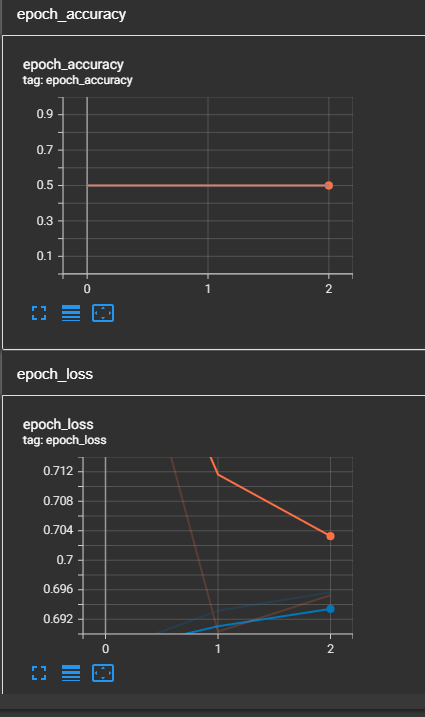

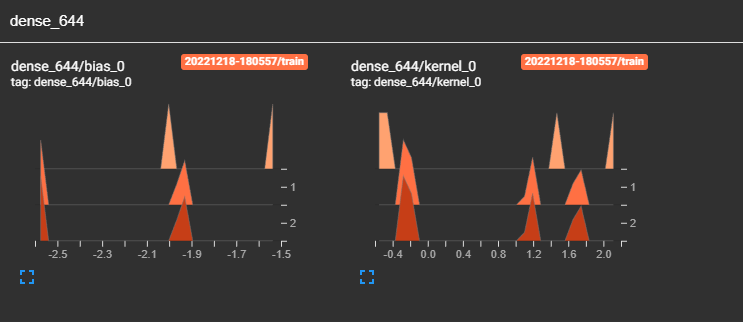

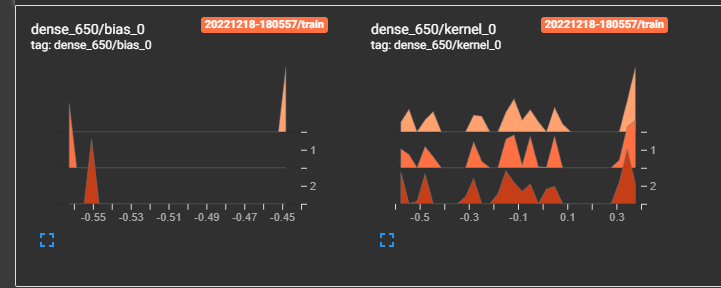

# Observations

- from the above plot 1 we can see that the accuracy did not changed much through all the epoch
- from the plot 2(dense_644) we can see that wights in the first dense layer are distributed in the range between -0.4 and 2 and it does not change much during the all epoch..since derivative of tanh function's max value is 1, it somewhat avoid the vanishing gradient problem but still weights are not distributed well...
- from the plot 3(dense_650) we can see that initial wights in the final dense layer are distributed in the range between -0.5 and 0.3 and it does not change much during the all epoch and since this is last layer the vanishing gradient does not affect this layers weight much so that the weights are reasonably distributed well...

<pre>
<b>Model-2</b>
<pre>
1. Use relu as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use RandomUniform(0,1) as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>

In [ ]:
def create_model_2():
  return tf.keras.models.Sequential([
    tf.keras.layers.Dense(2,activation="relu",input_shape=(2,),kernel_initializer=keras.initializers.RandomUniform(minval=-0, maxval=1)), #relu
    tf.keras.layers.Dense(10, activation="relu",kernel_initializer=keras.initializers.RandomUniform(minval=-0, maxval=1)),                #RandomUniform(0,1)
    tf. keras.layers.Dense(10, activation="relu",kernel_initializer=keras.initializers.RandomUniform(minval=-0, maxval=1)),
    tf.keras.layers.Dense(10, activation="relu",kernel_initializer=keras.initializers.RandomUniform(minval=-0, maxval=1)),
    tf. keras.layers.Dense(10, activation="relu",kernel_initializer=keras.initializers.RandomUniform(minval=-0, maxval=1)),
    tf. keras.layers.Dense(10, activation="relu",kernel_initializer=keras.initializers.RandomUniform(minval=-0, maxval=1)),
    tf.keras.layers.Dense(1, activation='softmax',kernel_initializer=keras.initializers.RandomUniform(minval=-0, maxval=1))
  ])

In [ ]:
model_2=create_model_2()
optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=False, name='SGD')
model_2.compile(optimizer,
              loss='BinaryCrossentropy',
              metrics=['accuracy'])
model_2.fit(x=x_train, 
          y=y_train,  
          epochs=15, 
          validation_data=(x_test, y_test),callbacks=[cus_metrics,checkpoint,tensorboard_callback,earlystop ]
          )

Epoch 1/15
  1/469 [..............................] - ETA: 3:51 - loss: 195.2360 - accuracy: 0.6562

157/157 [==============================] - 0s 1ms/step
Micro F1 Score: 0.5000, AUC Score: 0.5000

Epoch 1: val_accuracy did not improve from 0.50000
469/469 [==============================] - 3s 5ms/step - loss: 1.1083 - accuracy: 0.5000 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 2/15
157/157 [==============================] - 0s 1ms/step
Micro F1 Score: 0.5000, AUC Score: 0.5000

Epoch 2: val_accuracy did not improve from 0.50000
469/469 [==============================] - 2s 5ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/15
157/157 [==============================] - 0s 1ms/step
Micro F1 Score: 0.5000, AUC Score: 0.5000

Epoch 3: val_accuracy did not improve from 0.50000
469/469 [==============================] - 2s 5ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3: early stopping


In [ ]:
!rm -rf ./logs/ 

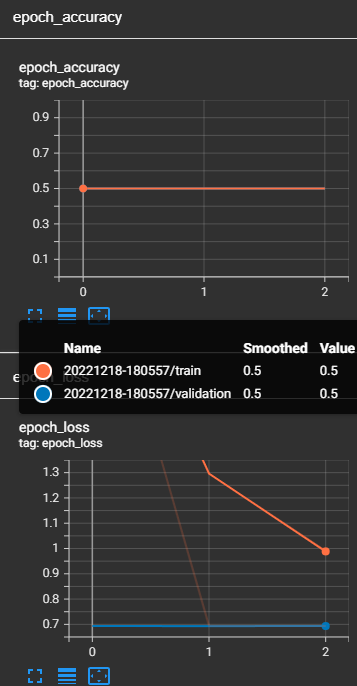

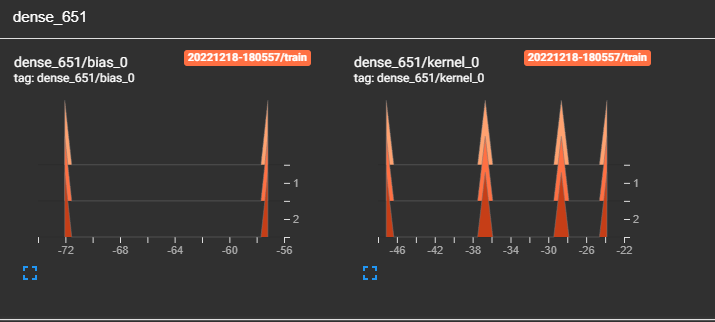

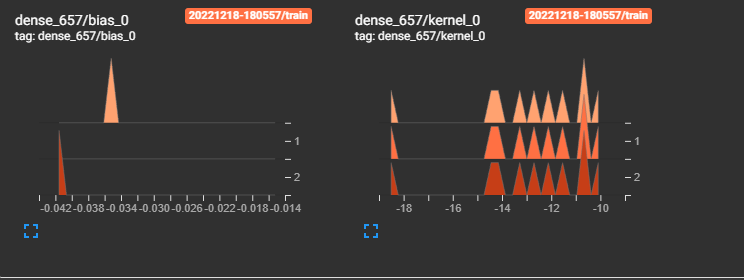

# Observations

- from the above plot 1 we can see that the accuracy did not changed much through all the epoch and train loss reduces from 2.3 to 1.
- from the plot 2(dense_651) we can see that wights in the first dense layer are distributed in the range between -46 and -22 and it does not change much during the all epoch..since derivative of relu function 1 for the positve value, it avoid the vanishing gradient problem but tbere is a high chance for exploding gradient problem...and due to that weights in the first layers are not well distributed
- from the plot 3(dense_657) we can see that  wights in the final dense layer are distributed in the range between -18 and -0 and it does not change much during the all epoch and since this is last layer there is no vanishing gradient probelm as well as not much of emploding gradient probelm also and the weights are reasonably distributed well...

<pre>
<b>Model-3</b>
<pre>
1. Use relu as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use he_uniform() as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>

In [ ]:
def create_model_3():
  return tf.keras.models.Sequential([
    tf.keras.layers.Dense(2,activation="relu",input_shape=(2,),kernel_initializer=keras.initializers.he_uniform()), #relu
    tf.keras.layers.Dense(10, activation="relu",kernel_initializer=keras.initializers.he_uniform()),                #he_uniform()
    tf. keras.layers.Dense(10, activation="relu",kernel_initializer=keras.initializers.he_uniform()),
    tf.keras.layers.Dense(10, activation="relu",kernel_initializer=keras.initializers.he_uniform()),
    tf. keras.layers.Dense(10, activation="relu",kernel_initializer=keras.initializers.he_uniform()),
    tf. keras.layers.Dense(10, activation="relu",kernel_initializer=keras.initializers.he_uniform()),
    tf.keras.layers.Dense(1, activation='sigmoid',kernel_initializer=keras.initializers.he_uniform())
  ])

In [ ]:
model_3=create_model_3()
optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=False, name='SGD')
model_3.compile(optimizer,
              loss='BinaryCrossentropy',
              metrics=['accuracy'])
model_3.fit(x=x_train, 
          y=y_train,  
          epochs=10, 
          validation_data=(x_test, y_test),callbacks=[cus_metrics,checkpoint,tensorboard_callback,earlystop ]
          )

Epoch 1/10
157/157 [==============================] - 0s 1ms/step
Micro F1 Score: 0.5718, AUC Score: 0.5718

Epoch 1: val_accuracy improved from 0.50000 to 0.57180, saving model to model_save/weights-01-0.5718.hdf5
469/469 [==============================] - 3s 5ms/step - loss: 0.6804 - accuracy: 0.5577 - val_loss: 0.6756 - val_accuracy: 0.5718
Epoch 2/10
157/157 [==============================] - 0s 1ms/step
Micro F1 Score: 0.5842, AUC Score: 0.5842

Epoch 2: val_accuracy improved from 0.57180 to 0.58420, saving model to model_save/weights-02-0.5842.hdf5
469/469 [==============================] - 2s 5ms/step - loss: 0.6692 - accuracy: 0.5848 - val_loss: 0.6688 - val_accuracy: 0.5842
Epoch 3/10
157/157 [==============================] - 0s 1ms/step
Micro F1 Score: 0.5912, AUC Score: 0.5912

Epoch 3: val_accuracy improved from 0.58420 to 0.59120, saving model to model_save/weights-03-0.5912.hdf5
469/469 [==============================] - 2s 4ms/step - loss: 0.6676 - accuracy: 0.5893 - va

In [ ]:
!rm -rf ./logs/ 

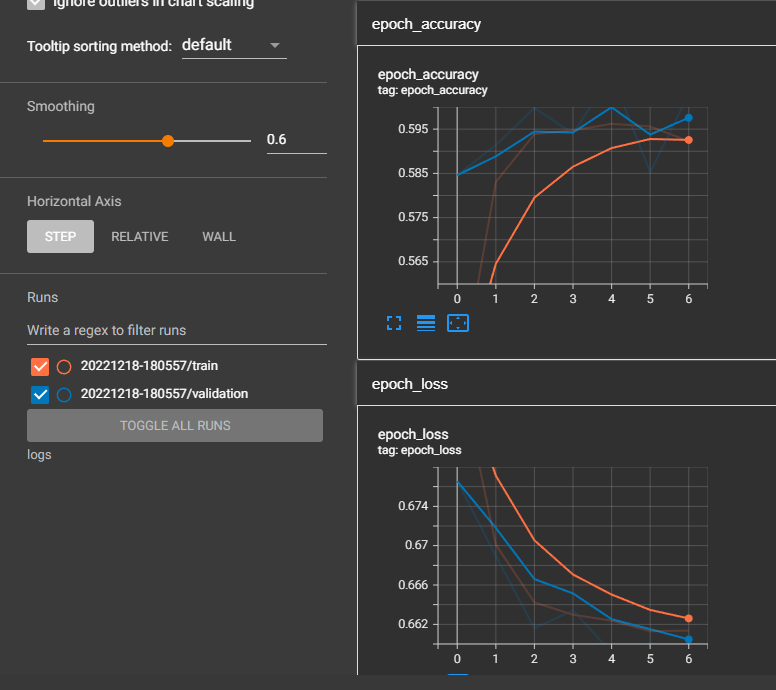

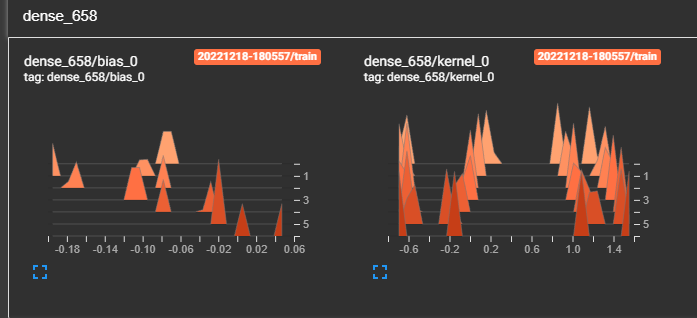

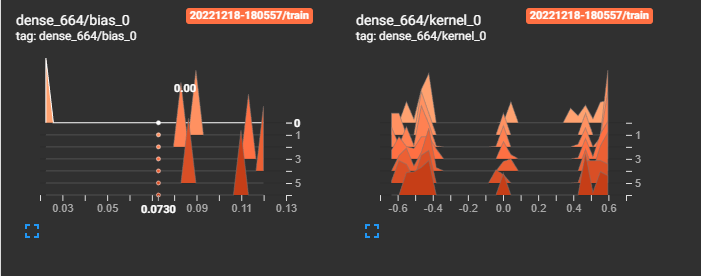

# Observations

- from the above plot 1 we can see that the accuracy did not changed much through all the epoch and train loss and test loss reduces from 0.68 to 0.66.
- from the plot 2(dense_658) we can see that he_uniform() initailisation helps wights in the first dense layer are distributed in the range between -0.6 and +1.4..so there are distribured around the mean and it does change much during the all epoch..since derivative of relu function 1 for the positve value, it avoid the vanishing gradient problem but there is a high chance for exploding gradient problem..but this method of weight intialisation avoid those exploding gradient problem also....but weights in the first layers are not well distributed
- from the plot 3(dense_664) we can see that  wights in the final dense layer are distributed in the range between -0.6 and 0.6 and it does not change much during the all epoch and since this is last layer there is no vanishing gradient probelm as well as not much of emploding gradient probelm also but  the weights are not reasonably distributed well...




<pre>
<b>Model-4</b>
<pre>
1. Try with any values to get better accuracy/f1 score.  
</pre>
</pre>

In [ ]:
#model 4 build with relu as a activation function and glorot_normal() as the weight intialisation method and adam as an optimizer.....

def create_model_4():
  return tf.keras.models.Sequential([
    tf.keras.layers.Dense(10,activation="relu",input_shape=(2,),kernel_initializer=keras.initializers.glorot_normal()),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(10, activation="relu",kernel_initializer=keras.initializers.glorot_normal()),
    tf.keras.layers.Dropout(0.8),
    tf. keras.layers.Dense(10, activation="relu",kernel_initializer=keras.initializers.glorot_normal()),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(10, activation="relu",kernel_initializer=keras.initializers.glorot_normal()),
    tf.keras.layers.Dropout(0.8),
    tf. keras.layers.Dense(10, activation="relu",kernel_initializer=keras.initializers.glorot_normal()),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(10, activation="relu",kernel_initializer=keras.initializers.glorot_normal()),
    tf.keras.layers.Dense(1, activation='sigmoid',kernel_initializer=keras.initializers.glorot_normal())
  ])

In [ ]:
model_4=create_model_4()
optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=False, name='adam')
#optimizer = tf.keras.optimizers.Adam(0.01)
model_4.compile(optimizer,
              loss='BinaryCrossentropy',
             metrics=['accuracy'])
model_4.fit(x=x_train, 
          y=y_train,  
          epochs=5, 
          validation_data=(x_test, y_test),callbacks=[cus_metrics,checkpoint,tensorboard_callback,earlystop ]
          )

Epoch 1/5
  1/469 [..............................] - ETA: 4:42 - loss: 0.6784 - accuracy: 0.4688

157/157 [==============================] - 0s 1ms/step
Micro F1 Score: 0.5000, AUC Score: 0.5000

Epoch 1: val_accuracy did not improve from 0.59820
469/469 [==============================] - 3s 5ms/step - loss: 0.7130 - accuracy: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
157/157 [==============================] - 0s 1ms/step
Micro F1 Score: 0.5000, AUC Score: 0.5000

Epoch 2: val_accuracy did not improve from 0.59820
469/469 [==============================] - 2s 5ms/step - loss: 0.6933 - accuracy: 0.5021 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 3/5
157/157 [==============================] - 0s 1ms/step
Micro F1 Score: 0.5000, AUC Score: 0.5000

Epoch 3: val_accuracy did not improve from 0.59820
469/469 [==============================] - 2s 5ms/step - loss: 0.6934 - accuracy: 0.4948 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3: early stopping


In [ ]:
!kill 2158

In [ ]:
!rm -rf ./logs/ 

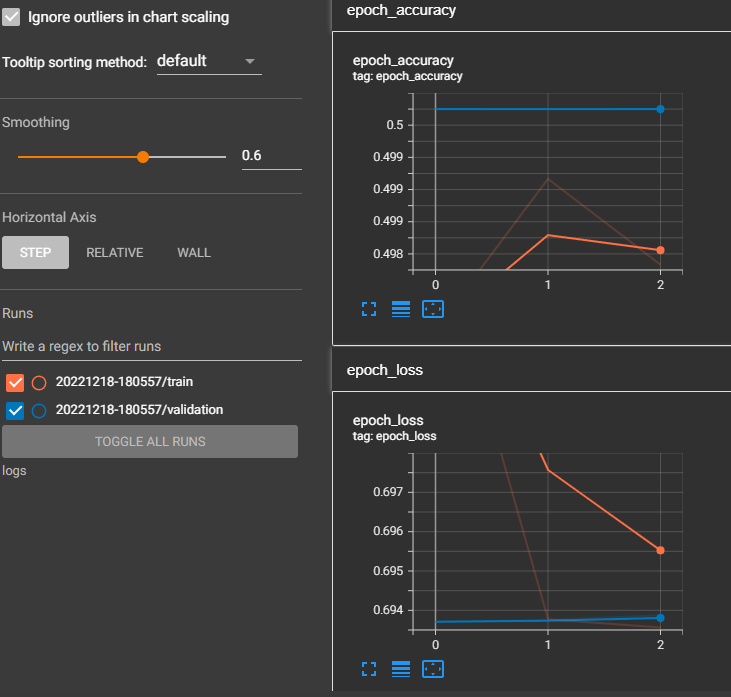

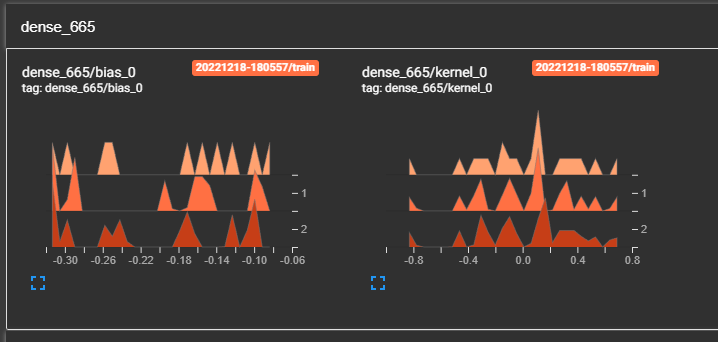

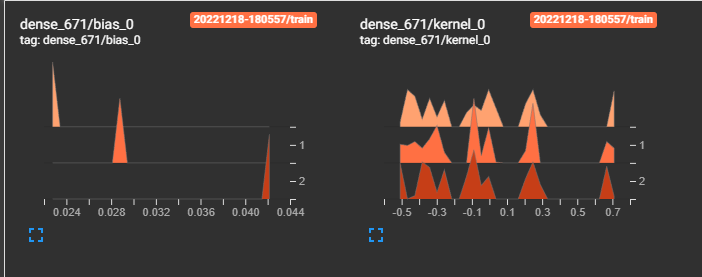

# Observations

- from the above plot 1 we can see that the accuracy did not changed much through all the epoch and train loss and test loss is not change significantly
- from the plot 2(dense_665) we can see that glorot_normal() initailisation helps wights in the first dense layer are distributed in the range between -0.8 and 0.8..and the weights are well distributed...so there are distribured around the mean and it does not change much during the all epoch..since derivative of relu function 1 for the positve value, it avoid the vanishing gradient problem but there is a high chance for exploding gradient problem..but this method of weight intialisation avoid those exploding gradient problem also...
- from the plot 3(dense_671) we can see that  wights in the final dense layer are distributed in the range between -0.5 and 0.7 and it does not change much during the all epoch and since this is last layer there is no vanishing gradient probelm as well as not much of emploding gradient probelm also and  the weights are reasonably distributed well...